# Forest Fire Risk Analysis

This notebook reads data from `data/forestfires.csv` and analyzes environmental risk factors for forest fires in Portugal.

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

df_raw = pd.read_csv('forestfires.csv')
df_raw.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Cleaning the dataset by dropping unused columns like month, day, area, X and Y. DMC and DC are also unitless and open ended variables with little chance of producing values correlating to fire behavior according to the National Wildfire Coordinating Group's Fire Weather Index system.

In [40]:
df = df_raw.drop(['X','Y','month','day','area','DMC','DC'], axis=1)
df.head()

,FFMC,ISI,temp,RH,wind,rain
0,86.2,5.1,8.2,51,6.7,0.0
1,90.6,6.7,18.0,33,0.9,0.0
2,90.6,6.7,14.6,33,1.3,0.0
3,91.7,9.0,8.3,97,4.0,0.2
4,89.3,9.6,11.4,99,1.8,0.0


Displaying a scatterplot of Initial Spread Index (ISI) vs Burned Area in hectares, illustrating their correlation.

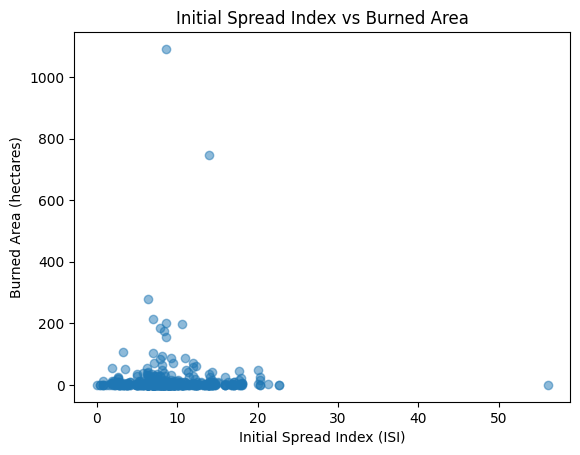

In [41]:
plt.scatter(df['ISI'], df_raw['area'], alpha=0.5)
plt.xlabel('Initial Spread Index (ISI)')
plt.ylabel('Burned Area (hectares)')
plt.title('Initial Spread Index vs Burned Area')
plt.show()

Creating a correlation matrix, dropping ISI, and analyzing how the different environmental factors are correlated.

<Axes: >

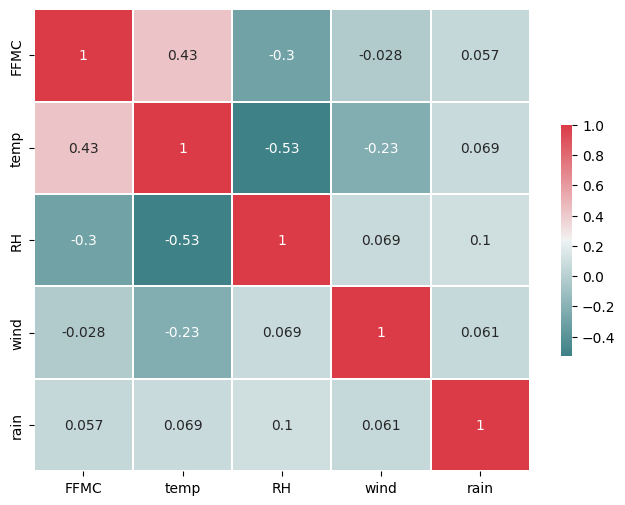

In [42]:
corr_matrix = df.drop(['ISI'], axis=1).corr()
f, ax = plt.subplots(figsize=(8,6))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, annot=True, linewidth = 0.1, cbar_kws={"shrink": .5})

Displaying a scatterplot matrix in order to visualize correlation.

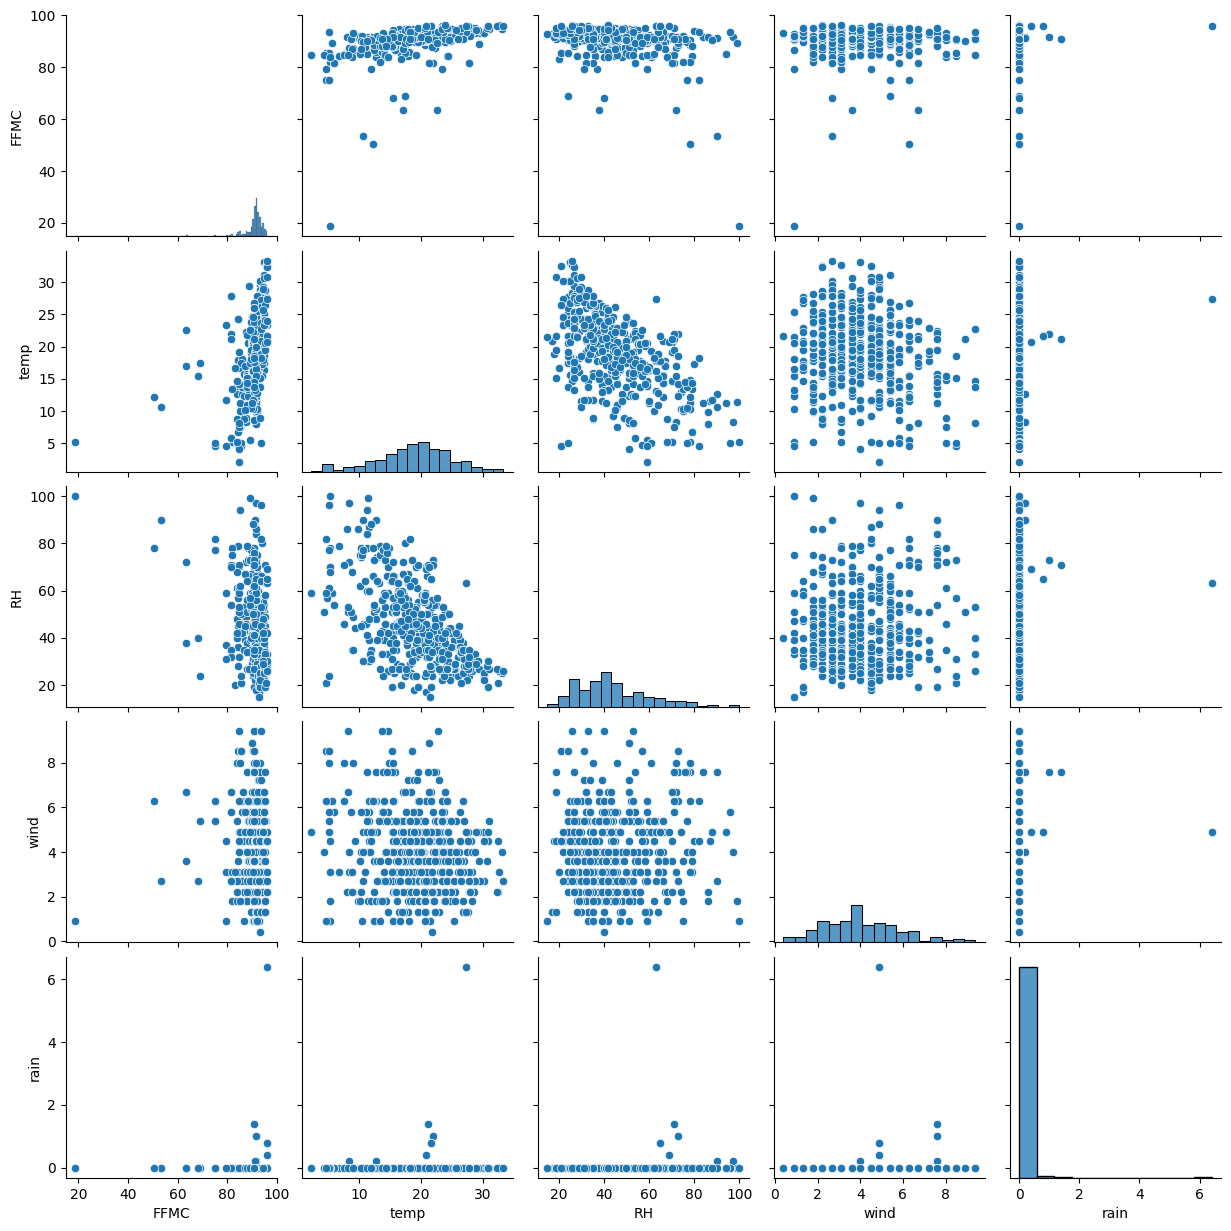

In [43]:
sns.pairplot(df[['FFMC', 'temp', 'RH', 'wind', 'rain']])
plt.show()

Comparing the environmental factors in the matrix to see what is more likely correlated with ISI, a key input for fire behavior predictions in the Fire Behavior Prediction system.

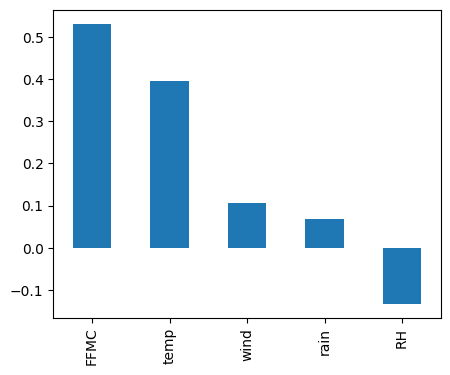

In [44]:
corr_with_isi = df.corr()['ISI'].sort_values(ascending=False)
plt.figure(figsize=(5,4))
corr_with_isi.drop('ISI').plot.bar()
plt.show();

Defining the target variable (ISI) and the predictors (FFMC, temp, wind, rain, RH), then splitting data into training and testing sets.

In [45]:
y = df['ISI']
X = df.drop('ISI', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training the model and predicting on the test data.

In [46]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Plot actual vs predicted values.

Text(0.5, 1.0, 'Actual vs Predicted Values')

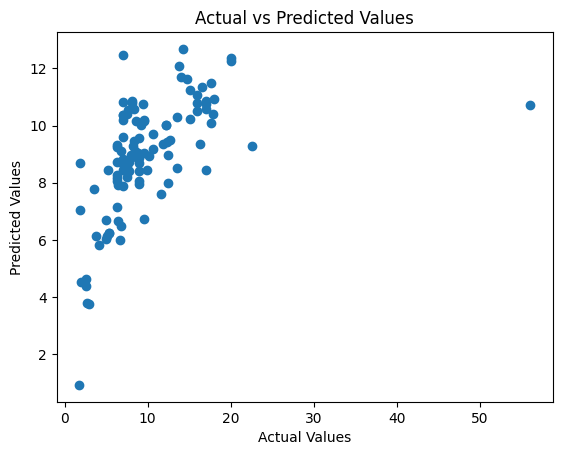

In [47]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

Calculating mean squared error (MSE) on the test data.

In [48]:
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

Mean squared error:  32.79463158844334


The MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates a that the model was a good fit for the data. In this case, the MSE of 32.79 suggests that the model has a moderate level of accuracy in predicting the ISI based on the other variables in the dataset.

However, it's important to note that a single metric like MSE doesn't tell the whole story, and it's always a good idea to evaluate the performance of the model using multiple metrics and visualizations.

Printing the model's coefficients.

In [49]:
print('Model coefficients: ', model.coef_)

Model coefficients:  [0.31931749 0.25420499 0.0461713  0.4379003  0.1333694 ]


The most important variables that are correlated to the target variable (ISI) are identified based on the coefficient values: wind (0.4379003), FFMC (0.31931749), temp (0.25420499)

These variables are positively correlated to the target variable, meaning that as the values of these variables increase, so does the ISI. The other two variables (RH and rain) have smaller coefficients, indicating weaker correlations.

The mean squared error of 32.79 indicates that the model's predictions are on average off by about 5.73 units (square root of 32.79) of ISI. This could be considered relatively high or low depending on the context of the problem and the specific requirements of the model.

Calculating R-squared value.

In [50]:
r_squared = r2_score(y_test, y_pred)
print('R-squared value: ', r_squared)

R-squared value:  0.21417085298150684


The R-squared value of 0.214 indicates that the model explains only 21.4% of the variance in the target variable, which is not very high. This means that there might be other factors that are not included in the model that could better explain the variance in the target variable.

Additionally, it is important to consider that R-squared can be misleading in some cases, especially if the model is overfitting the data. In such cases, the R-squared value might be high, but the model might not perform well on new, unseen data.

Performing 5-fold cross-validation.

In [51]:
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross-validation scores: ', cv_scores)
print('Average cross-validation score: ', np.mean(cv_scores))

Cross-validation scores:  [ 0.20715512  0.46646877  0.48261266 -1.41171597  0.42413551]
Average cross-validation score:  0.03373121772237338


The cross-validation helps evaluate the model's performance by splitting the data into multiple folds and training the model on different combinations of the folds. The average cross-validation score is an indicator of the model's generalization ability.

In this case, the cross-validation scores range from -1.4 to 0.48, indicating that the model has a high variance and is overfitting the data. The average cross-validation score is 0.03, which is close to zero, suggesting that the model is not performing well on unseen data.

With such cross-validation scores and the calculated R-squared value of 0.214, it can be concluded that the model is not a good fit for the data.